In [1]:
import json
import pandas as pd
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif,  chi2
from sklearn import svm
from scipy.sparse import csr_matrix
from imblearn.under_sampling import RandomUnderSampler


In [2]:
dom1 = []
dom2 = []
test_set = []
with open('../data/domain1_train.json', 'r') as file:
    for line in file:
        dom1.append(json.loads(line))
        
with open('../data/domain2_train.json', 'r') as file:
    for line in file:
        dom2.append(json.loads(line))
        
sam = pd.read_csv("../data/sample.csv")

with open('../data/test_set.json', 'r') as file:
    for line in file:
        test_set.append(json.loads(line))
        
dom1 = pd.DataFrame.from_dict(dom1)
dom2 = pd.DataFrame.from_dict(dom2)
dom2 = dom2[dom2['text'].apply(len) > 0]
test_set = pd.DataFrame.from_dict(test_set)
        

In [287]:
# print(len(dom1))
# print(len(dom2))
# print(len(sam))
# print(len(test_set))

19500
14899
1000
1000


In [243]:
# dom1['label'].value_counts()
# print(len(dom2.loc[dom2['label']==0]))
# print(len(dom2.loc[dom2['label']==1]))

12750
2150


<AxesSubplot:ylabel='count'>

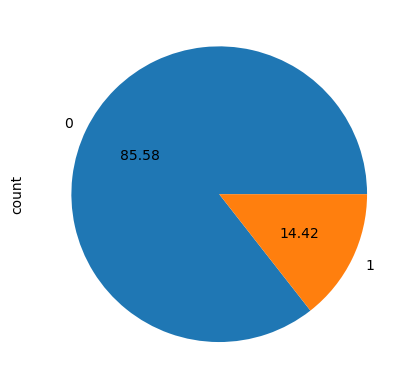

In [3]:
dom2['label'].value_counts().plot.pie(autopct='%.2f')

In [4]:
dom1['model'] = np.where(dom1['label'] == 1, np.NaN, 7)
df_full = pd.concat([dom1,dom2])

In [24]:
def to_sparse_matrix(sequences, vocab_size):
    indptr = [0]
    indices = []
    data = []
    for seq in sequences:
        feature_counter = {}
        for index in seq:
            if index != 0:  # Skip 0s, other words
                if index not in feature_counter:
                    feature_counter[index] = 1
                else:
                    feature_counter[index] += 1
        indices.extend(feature_counter.keys())
        data.extend(feature_counter.values())
        indptr.append(len(indices))
    return csr_matrix((data, indices, indptr), dtype=int, shape=(len(sequences), vocab_size + 1))

vocab_size = 4999
X = to_sparse_matrix(df_full['text'], vocab_size)
y = df_full['label']

In [30]:
# X = pd.DataFrame([pd.Series(x) for x in X])
y = df_full['label']

selector = SelectKBest(chi2, k=2500)
X = selector.fit_transform(X, y)

X_pre = to_sparse_matrix(test_set['text'], vocab_size)
X_pre_new = selector.transform(X_pre)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)X

<34399x2500 sparse matrix of type '<class 'numpy.int64'>'
	with 1297178 stored elements in Compressed Sparse Row format>

In [18]:
from imblearn.under_sampling import RandomUnderSampler

In [34]:
rus = RandomUnderSampler(sampling_strategy=1)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

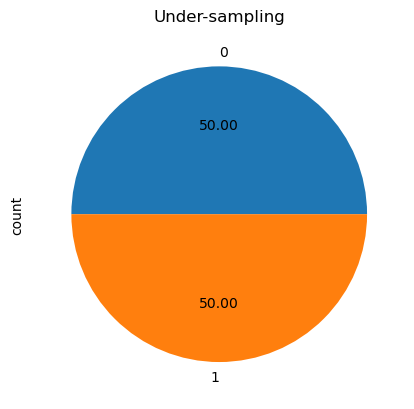

In [35]:
ax = y_train_rus.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef
model = svm.SVC(gamma='scale', C=10, class_weight = 'balanced')
model.fit(X_train_rus, y_train_rus)
model.fit(X_train_rus, y_train_rus)
y_test_pred = model.predict(X_test)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
df_labels = pd.Series(['MCC_test'], name = 'Performance_metric_names')
df_values = pd.Series([mcc_test], name = 'Performance_metric_values')
df2 = pd.concat([df_labels, df_values], axis=1)
print(df2)


  Performance_metric_names  Performance_metric_values
0                 MCC_test                   0.364166


In [45]:
test_pre = model.predict(X_pre_new)
result = pd.DataFrame({
    'class': test_pre,
})
result['id'] = result.index
result = result[['id'] + [col for col in result.columns if col != 'id']]
result['class'].value_counts()

result.to_csv('result_imb.csv', index=False)

In [46]:
result['class'].value_counts()

class
0    672
1    328
Name: count, dtype: int64

## Resampling

In [48]:
#让dom2的label，model分布都平均，差不多307一组，st 307行是label 1 标为model 5，再从dom1里取307个label1和307个label0，人工的model是nan

dom2_0 = dom2.loc[dom2['label']==0]
dom2_1 = dom2.loc[dom2['label']==1]

length_dom2_1 = len(dom2_1)
mol_num = len(dom2['model'].value_counts())
sam_dom2_0 = dom2_0.groupby('model').apply(lambda x: x.sample(n=int(length_dom2_1/mol_num)))
sam_dom2_0.reset_index(drop=True, inplace=True)
dom2_new = result = pd.concat([dom2_1, sam_dom2_0])

sampled_dom1 = dom1.groupby('label').apply(lambda x: x.sample(n=int(length_dom2_1/mol_num)))
sampled_dom1.reset_index(drop=True, inplace=True)

df = pd.concat([sampled_dom1, dom2_new])

In [516]:
# print(df['label'].value_counts())
# print(df['model'].value_counts())


label
0    2456
1    2456
Name: count, dtype: int64
model
0.0    307
1.0    307
2.0    307
3.0    307
4.0    307
5.0    307
6.0    307
Name: count, dtype: int64


In [49]:
df = df.sample(frac=1).reset_index(drop=True)
df = df.drop(['model'], axis=1)

In [50]:
def to_sparse_matrix(sequences, vocab_size):
    indptr = [0]
    indices = []
    data = []
    for seq in sequences:
        feature_counter = {}
        for index in seq:
            if index != 0:  # Skip 0s, other words
                if index not in feature_counter:
                    feature_counter[index] = 1
                else:
                    feature_counter[index] += 1
        indices.extend(feature_counter.keys())
        data.extend(feature_counter.values())
        indptr.append(len(indices))
    return csr_matrix((data, indices, indptr), dtype=int, shape=(len(sequences), vocab_size + 1))

vocab_size = 4999
X = to_sparse_matrix(df['text'], vocab_size)

In [51]:
print(X)

  (0, 79)	1
  (0, 512)	1
  (0, 41)	1
  (0, 359)	1
  (0, 54)	1
  (0, 844)	1
  (0, 1)	5
  (0, 99)	10
  (0, 1406)	1
  (0, 94)	6
  (0, 105)	9
  (0, 11)	7
  (0, 3)	5
  (0, 114)	2
  (0, 2328)	1
  (0, 809)	2
  (0, 39)	1
  (0, 373)	1
  (0, 7)	1
  (0, 58)	3
  (0, 111)	10
  (0, 15)	4
  (0, 536)	2
  (0, 50)	2
  (0, 20)	2
  :	:
  (4911, 28)	2
  (4911, 54)	1
  (4911, 2533)	1
  (4911, 58)	1
  (4911, 179)	2
  (4911, 1836)	1
  (4911, 553)	1
  (4911, 242)	1
  (4911, 810)	1
  (4911, 2964)	1
  (4911, 2419)	1
  (4911, 3066)	1
  (4911, 775)	1
  (4911, 3203)	1
  (4911, 131)	1
  (4911, 297)	1
  (4911, 82)	1
  (4911, 2749)	1
  (4911, 566)	1
  (4911, 646)	1
  (4911, 3389)	1
  (4911, 2707)	1
  (4911, 1858)	1
  (4911, 1150)	1
  (4911, 879)	1


In [97]:
y = df['label']

selector = SelectKBest(chi2, k=3000)
X_new = selector.fit_transform(X, y)

X_pre = to_sparse_matrix(test_set['text'], vocab_size)
X_pre_new = selector.transform(X_pre)

In [301]:
# # 试一下转成mean，std为feature
# df['feature_mean'] = df['text'].apply(np.mean)
# df['feature_std'] = df['text'].apply(np.std)
# X = df[['feature_mean', 'feature_std']]
# y = df['label']

# test_set['feature_mean'] = test_set['text'].apply(np.mean)
# test_set['feature_std'] = test_set['text'].apply(np.std)
# X_pre = test_set[['feature_mean', 'feature_std']]

In [53]:
X

<4912x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 344533 stored elements in Compressed Sparse Row format>

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
model = svm.SVC(C=10, gamma=0.001)
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(f"Test score: {score}")

Test score: 0.7070193285859614


In [95]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

k_values = []
accuracies = []


for k in range(100, (X_train.shape[1] + 1),100):
    # Apply SelectKBest class to extract top k best features
    best_features = SelectKBest(score_func=f_classif, k=k)
    X_train_kbest = best_features.fit_transform(X_train, y_train)
    X_test_kbest = best_features.transform(X_test)
    # train classifier
    classifier = SVC(C=10, gamma=0.001)
    classifier.fit(X_train_kbest, y_train)
    # Predict
    y_pred = classifier.predict(X_test_kbest)
    acc = accuracy_score(y_test, y_pred)
    
    k_values.append(k)
    accuracies.append(acc)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0 0 0 

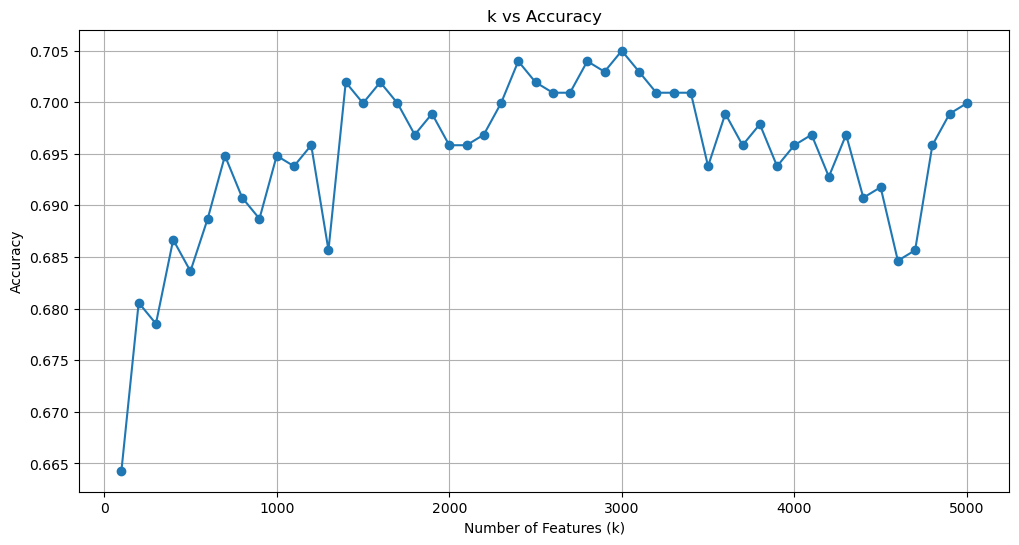

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.xlabel('Number of Features (k)')
plt.ylabel('Accuracy')
plt.title('k vs Accuracy')
plt.grid(True)
plt.show()


In [100]:
test_pre = model.predict(X_pre_new)
result = pd.DataFrame({
    'class': test_pre,
})
result['id'] = result.index
result = result[['id'] + [col for col in result.columns if col != 'id']]
result['class'].value_counts()

class
1    539
0    461
Name: count, dtype: int64

In [101]:
result.to_csv('result.csv', index=False)

In [682]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6256358087487284


In [683]:
test_pre = clf.predict(X_pre_new)
result = pd.DataFrame({
    'class': test_pre,
})
result['id'] = result.index
result = result[['id'] + [col for col in result.columns if col != 'id']]
result['class'].value_counts()


class
0    561
1    439
Name: count, dtype: int64

In [684]:
result.to_csv('result.csv', index=False)

In [644]:
from sklearn.svm import SVC  
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return SVC(kernel='poly', degree=8, gamma="auto")
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVC(kernel='rbf', gamma="auto")
    elif ktype == 2:
        # Sigmoid kernal
        return SVC(kernel='sigmoid', gamma="auto")
    elif ktype == 3:
        # Linear kernal
        return SVC(kernel='linear', gamma="auto")

In [646]:
from sklearn.metrics import classification_report, confusion_matrix  
for i in range(4):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.20)# Train a SVC model using different kernal
    svclassifier = getClassifier(i) 
    svclassifier.fit(X_train, y_train)# Make prediction
    y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", kernels[i], "kernel")
    print(classification_report(y_test,y_pred))

Evaluation: Polynomial kernel
              precision    recall  f1-score   support

           0       0.51      0.96      0.67       481
           1       0.77      0.12      0.21       502

    accuracy                           0.53       983
   macro avg       0.64      0.54      0.44       983
weighted avg       0.64      0.53      0.43       983

Evaluation: RBF kernel
              precision    recall  f1-score   support

           0       0.63      0.80      0.70       510
           1       0.69      0.49      0.57       473

    accuracy                           0.65       983
   macro avg       0.66      0.64      0.64       983
weighted avg       0.66      0.65      0.64       983

Evaluation: Sigmoid kernel
              precision    recall  f1-score   support

           0       0.58      0.61      0.60       508
           1       0.56      0.52      0.54       475

    accuracy                           0.57       983
   macro avg       0.57      0.57      0.57     

In [600]:
grid.best_estimator_

SVC(C=10, gamma=0.001)

In [647]:
from sklearn.model_selection import GridSearchCV

In [648]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   7.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   6.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   6.9s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   8.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   7.2s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   3.2s
[CV] END .....................C=0.1, gamma=1, k

In [662]:
print(grid.best_estimator_)

SVC(C=10, gamma=0.001)


In [663]:
accuracy_score(y_test, grid.best_estimator_.predict(X_test))

0.6927772126144456

In [664]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))#Output

[[371 122]
 [180 310]]
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       493
           1       0.72      0.63      0.67       490

    accuracy                           0.69       983
   macro avg       0.70      0.69      0.69       983
weighted avg       0.70      0.69      0.69       983



In [665]:
#test_pre_tun = grid.predict(X_pre_new)
test_pre_tun = grid.best_estimator_.predict(X_pre_new)
result_tun = pd.DataFrame({
    'class': test_pre_tun,
})
result_tun['id'] = result_tun.index
result_tun = result_tun[['id'] + [col for col in result_tun.columns if col != 'id']]
result_tun['class'].value_counts()

class
1    548
0    452
Name: count, dtype: int64

In [666]:
result['class'].value_counts()

class
1    553
0    447
Name: count, dtype: int64

In [667]:
result_tun.to_csv('result_tun.csv', index=False)

In [678]:
a = pd.read_csv('result_tun.csv')
b = pd.read_csv('result.csv')
c = pd.read_csv('1.csv')

In [676]:
a['class'].value_counts()

class
1    548
0    452
Name: count, dtype: int64

In [679]:
c['class'].value_counts()

class
1    548
0    452
Name: count, dtype: int64

In [677]:
b['class'].value_counts()

class
1    553
0    447
Name: count, dtype: int64

In [497]:
from sklearn.datasets import make_classification

In [466]:
df1 = pd.concat([sampled_dom1, dom2])
df1 = df1.drop(['model'], axis=1)

In [554]:
X1 = to_sparse_matrix(df1['text'], vocab_size)
y1 = df1['label']
selector = SelectKBest(chi2, k=1000)
X_new1 = selector.fit_transform(X1, y1)

X_train, X_test, y_train, y_test = train_test_split(X_new1, y1, test_size=0.33, random_state=42)

In [562]:
from sklearn.svm import OneClassSVM
# Extracting the majority class for training
X_train_majority = X_train[y_train==0]

# Defining and training the model
one_class_svm = OneClassSVM(kernel='rbf', nu=0.1, gamma='auto')
one_class_svm.fit(X_train_majority)

OneClassSVM(gamma='auto', nu=0.1)

In [563]:
# Predict (1 for inliers which are majority class, -1 for outliers which are minority class)
y_pred = one_class_svm.predict(X_test)

# Convert predictions to match original labels
# Inliers (majority class) are labelled 0 and outliers (minority class) are labelled 1
y_pred = np.where(y_pred == 1, 0, 1)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4327
           1       0.26      0.19      0.22       793

    accuracy                           0.79      5120
   macro avg       0.56      0.54      0.55      5120
weighted avg       0.77      0.79      0.78      5120

Confusion Matrix:
[[3892  435]
 [ 643  150]]


In [564]:
y_res = one_class_svm.predict(X_pre_new)
result1 = np.where(y_res == 1, 0, 1)

In [565]:
result1 = pd.DataFrame({
    'class': result1,
})
result1['id'] = result1.index
result1 = result1[['id'] + [col for col in result.columns if col != 'id']]


In [566]:
result1['class'].value_counts()

class
0    762
1    238
Name: count, dtype: int64

In [567]:
result1.to_csv('result1.csv', index=False)

In [230]:
# selector = SelectKBest(f_classif, k=200)  
# X_new = selector.fit_transform(X, y)

# mask = selector.get_support()
# selected_features = X.columns[mask]
# print('Selected features:', selected_features.tolist())

Selected features: ['feature_mean', 'feature_std']


In [343]:
# from sklearn.linear_model import LogisticRegression
# import numpy as np
# from sklearn.model_selection import train_test_split
# features = df['text']
# labels = df['label']
# max_length = max([len(f) for f in features])

# features_padded = np.array([f + [0]*(max_length - len(f)) for f in features])
# X_train, X_test, y_train, y_test = train_test_split(features_padded, labels, test_size=0.2, random_state=42)
# model = LogisticRegression()
# model.fit(X_train, y_train)

# score = model.score(X_test, y_test)
# print(f"Test score: {score}")


# x_pre = test_set['text']
# max_length = max([len(f) for f in x_pre])

# features_padded = np.array([f + [0]*(max_length - len(f)) for f in x_pre])

# len(features_padded[0])

In [569]:
X_train

<10393x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 387892 stored elements in Compressed Sparse Row format>

In [568]:
from sklearn.svm import SVC
clf = SVC(class_weight='balanced')
clf.fit(X_train, y_train)

SVC(class_weight='balanced')

In [571]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
clf = SVC()
clf.fit(X_resampled, y_resampled)

SVC()

In [572]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.svm import SVC

bbc = BalancedBaggingClassifier(base_estimator=SVC(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

bbc.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


BalancedBaggingClassifier(base_estimator=SVC(), random_state=0)

In [573]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.svm import SVC

bbc = BalancedBaggingClassifier(base_estimator=SVC(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

bbc.fit(X_train, y_train)


/opt/anaconda3/lib/python3.9/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


BalancedBaggingClassifier(base_estimator=SVC(), random_state=0)

In [574]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.83      0.85      4327
           1       0.24      0.28      0.26       793

    accuracy                           0.75      5120
   macro avg       0.55      0.56      0.55      5120
weighted avg       0.77      0.75      0.76      5120



In [575]:
result2 = clf.predict(X_pre_new)
result2 = pd.DataFrame({
    'class': result2,
})
result2['id'] = result2.index
result2 = result2[['id'] + [col for col in result2.columns if col != 'id']]

In [578]:
result2['class'].value_counts()

class
0    584
1    416
Name: count, dtype: int64

In [583]:
result2.to_csv('result2.csv', index=False)